In [1]:
#Importing dependancies
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [30]:
import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Grabs the last date entry in the data table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)


('2017-08-23',)


In [11]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data 
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()
#preview of the data
precipitation[:5]


[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22)]

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(precipitation)
prcp_df.sort_values("date")
prcp_df.head()


,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


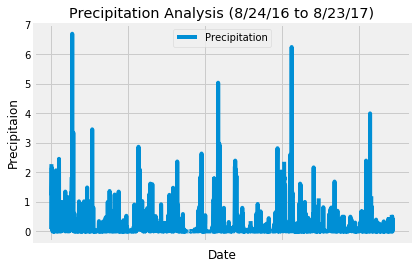

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot("date", "prcp")
plt.xlabel("Date")
plt.ylabel("Precipitaion")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"],loc="upper center")
plt.savefig("Precipitation analysis.png", dpi = 600)
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(stations))


There are 9 stations.


In [17]:
active_station = session.query(Measurement.station, func.count(Measurement.tobs)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).all()
active_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# most active station is the first station of the list active_station
most_active = active_station[0][0]


session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active).\
        filter(Measurement.date >="2016-08-23").all()



[(59.0, 83.0, 73.10795454545455)]

In [19]:
# Choose the station with the highest number of temperature observations.
st1 = (session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first())[0]
st1





'USC00519281'

In [20]:
# Query the last 12 months of temperature observation data for this station
temp_data= session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()
#created data frame of this data
temp_datadf = pd.DataFrame(temp_data)
temp_datadf.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


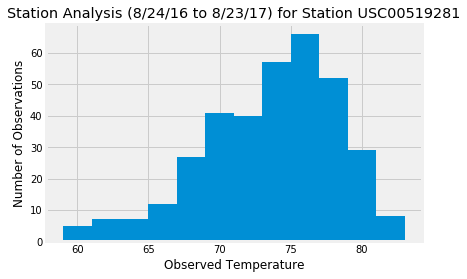

In [21]:
# plot the results as a histogram
#created 12 bins of the temperature range for the each bar in histogram
plt.hist(temp_datadf.tobs,12)
plt.xlabel("Observed Temperature")
plt.ylabel("Number of Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + most_active)
plt.savefig("StationAnalysis_Histogram.png", dpi=450)
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates."""
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2015-04-15', '2015-05-01'))

[(66.0, 73.57272727272728, 83.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#My trip itinerary
trip_start = dt.date(2019, 5, 5)
trip_end = dt.date(2019, 5, 17)

#I will have to subtract 2 years to estimate this years data
#because we don't have data of 2018
last_year = dt.timedelta(days=365*2)

#using the calc_temps function
my_estimation= calc_temps((trip_start-last_year), (trip_end-last_year))

print(my_estimation)



[(66.0, 75.3013698630137, 80.0)]


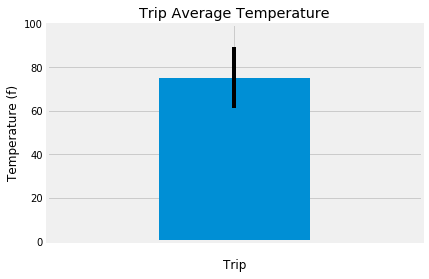

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
yerr = my_estimation[0][2]-my_estimation[0][0] #tmax-tmin
ax.bar(" ", my_estimation[0][1], yerr= yerr, align="center")
ax.set_title('Trip Average Temperature')
ax.set_ylabel("Temperature (f)")
ax.set_ylim(0,100)
ax.set_xlim(-1,1)
ax.set_xlabel("Trip")
plt.savefig("My_trip_TAVG.png",dpi=450)
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_rainfall = session.query(\
                Measurement.station, func.sum(Measurement.prcp),\
                Station.name, Station.latitude, Station.longitude, Station.elevation).\
                group_by(Measurement.station).\
                filter(Measurement.date >= (trip_start-last_year), Measurement.date <= (trip_end-last_year)).\
                filter(Measurement.station == Station.station).\
                order_by(func.sum(Measurement.prcp).desc()).all()
                
trip_rainfall




[('USC00516128',
  4.62,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  3.15,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 2.23, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830',
  1.86,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519523',
  0.8,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 0.07, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("05-17")

[(68.0, 74.45, 79.0)]

In [33]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
date1 = '2019-05-05'
date2 = '2019-05-17'

# Use the start and end date to create a range of dates
mydates = pd.date_range(date1, date2).tolist()


# Strip off the year and save a list of %m-%d strings
day_month= []
for i in range(13):
    md=datetime.datetime.strftime(mydates[i], "%m-%d")
    day_month.append(md)

# Loop through the list of %m-%d strings and calculate the normals for each date
for day in day_month:
    a =daily_normals(day)
    normals.append(a)
normals

[[(67.0, 73.39655172413794, 79.0)],
 [(66.0, 73.14035087719299, 80.0)],
 [(64.0, 71.78846153846153, 79.0)],
 [(65.0, 72.18867924528301, 80.0)],
 [(67.0, 72.9322033898305, 79.0)],
 [(64.0, 73.3157894736842, 78.0)],
 [(65.0, 73.61111111111111, 79.0)],
 [(65.0, 73.13793103448276, 79.0)],
 [(67.0, 73.14285714285714, 79.0)],
 [(63.0, 73.89285714285714, 80.0)],
 [(63.0, 73.69090909090909, 79.0)],
 [(68.0, 74.37931034482759, 80.0)],
 [(68.0, 74.45, 79.0)]]

In [34]:
#the list normals became list of list of tuples so, removed a layer of list
normals_=[normals[j][0] for j in range(len(normals))]
normals_

[(67.0, 73.39655172413794, 79.0),
 (66.0, 73.14035087719299, 80.0),
 (64.0, 71.78846153846153, 79.0),
 (65.0, 72.18867924528301, 80.0),
 (67.0, 72.9322033898305, 79.0),
 (64.0, 73.3157894736842, 78.0),
 (65.0, 73.61111111111111, 79.0),
 (65.0, 73.13793103448276, 79.0),
 (67.0, 73.14285714285714, 79.0),
 (63.0, 73.89285714285714, 80.0),
 (63.0, 73.69090909090909, 79.0),
 (68.0, 74.37931034482759, 80.0),
 (68.0, 74.45, 79.0)]

In [36]:
#Created datelist of my trip duration
datelist =[datetime.datetime.strftime(mydates[i], "%y-%m-%d") for i in range(len(mydates))]
date_col = pd.Series(datelist)

#created a dataframe of normals_
tripdf =pd.DataFrame(normals_, columns =["TMIN","TAVG","TMAX"])
tripdf["Date"]=date_col.values
tripdf


,TMIN,TAVG,TMAX,Date
0,67.0,73.396552,79.0,19-05-05
1,66.0,73.140351,80.0,19-05-06
2,64.0,71.788462,79.0,19-05-07
3,65.0,72.188679,80.0,19-05-08
4,67.0,72.932203,79.0,19-05-09
5,64.0,73.315789,78.0,19-05-10
6,65.0,73.611111,79.0,19-05-11
7,65.0,73.137931,79.0,19-05-12
8,67.0,73.142857,79.0,19-05-13
9,63.0,73.892857,80.0,19-05-14


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
